In [3]:
import pandas as pd

original_data = pd.read_csv (r'dataset/DP15_Bvot_T1T2.csv', header=0, sep=';')
original_data_canton = pd.read_excel(r'dataset/Dep_15_Resultats_T1_complet.xlsx', sheet_name='Cantons', header=2)

 
df = original_data.copy()
df_canton = original_data_canton.copy()

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/DP15_Bvot_T1T2.csv'

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421064 entries, 0 to 421063
Data columns (total 14 columns):
NUMTOUR       421064 non-null int64
CODDPT        421064 non-null object
CODSUBCOM     421064 non-null int64
LIBSUBCOM     421064 non-null object
CODBURVOT     421064 non-null object
CODCAN        421064 non-null int64
LIBCAN        421064 non-null object
NBRINS        421064 non-null int64
NBRVOT        421064 non-null int64
NBREXP        421064 non-null int64
NUMDEPCAND    421064 non-null int64
LIBLISEXT     421064 non-null object
CODNUA        421064 non-null object
NBRVOIX       421064 non-null int64
dtypes: int64(8), object(6)
memory usage: 45.0+ MB


In [3]:
def getDataFromDep(data, dep,col_dep_name, tour=None):
    if tour is not None:
        data = data[data.NUMTOUR == tour]
    return data[data[col_dep_name] == dep]
    


def saveData(data, loc):
    # save cher_data as excel
    writer = pd.ExcelWriter(loc)
    
    # write dataframe to excel
    data.to_excel(writer)

    # save the excel
    writer.save()

def prepareInputDataBvot(data):
    tmp = data[['NUMTOUR', 'CODDPT', 'CODSUBCOM', 'LIBSUBCOM', 'CODBURVOT', 'CODCAN',
           'LIBCAN', 'NBRINS', 'NBRVOT', 'NBREXP']].copy()

    # Compute missing data
    tmp['NBRABS'] = tmp['NBRINS'] - tmp['NBRVOT']
    tmp['NBRNULBLANC'] = tmp['NBRVOT'] - tmp['NBREXP']

    nuances = getAllNuances(data)
    statsFeatures = ['NBRVOT', 'NBREXP', 'NBRNULBLANC', 'NBRABS']
    idFeatures = ['CODDPT', 'CODCAN', 'CODSUBCOM', 'CODBURVOT']

    inscrits = tmp[idFeatures + ['NBRINS']].drop_duplicates()['NBRINS']
    stats = tmp[idFeatures + statsFeatures].drop_duplicates()[statsFeatures]
    ids = tmp[idFeatures].drop_duplicates()

    # Create [%Voix] and fill it
    voix = pd.DataFrame(0, index=data.index, columns=nuances)
    for parti in nuances:
        voix[parti][data['CODNUA']==parti] = data[data['CODNUA']==parti]['NBRVOIX']
    voix = pd.concat([tmp[idFeatures], voix], axis=1).groupby(idFeatures).sum()[nuances]
    voix.index = stats.index

    # Concat with computed stats and divide almost everything by Inscrits
    tmp = pd.concat([stats, voix], axis=1).divide(inscrits, axis=0)
    X = pd.concat([inscrits, tmp], axis=1)
    X.index = pd.MultiIndex.from_frame(ids)
    return X

def getAllNuances(data, colNuance='CODNUA', fmt='exploded'):
    if fmt not in ['exploded', 'line']:
        raise ValueError("format parameter must be 'exploded' or 'line'")
    
    if fmt == 'exploded':
        nuances = data[colNuance].unique()
    
    if fmt == 'line':
        nuances = np.array([])
        nuances_tmp = data[colNuance].fillna(0)
        for c in nuances_tmp:
            nuances = np.append(nuances, nuances_tmp[c])
        nuances = np.unique(nuances[nuances!=0])
    
    return sorted(nuances)



In [20]:
cher_data = getDataFromDep(df, str(18), 'CODDPT', tour=1)
cher_data_canton = getDataFromDep(df_canton, 18,'Code du département')

saveData(cher_data, 'dataset/dep_15_Bvote.xlsx')
cher_data.info()
cher_data_canton.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1820 entries, 42581 to 44400
Data columns (total 14 columns):
NUMTOUR       1820 non-null int64
CODDPT        1820 non-null object
CODSUBCOM     1820 non-null int64
LIBSUBCOM     1820 non-null object
CODBURVOT     1820 non-null object
CODCAN        1820 non-null int64
LIBCAN        1820 non-null object
NBRINS        1820 non-null int64
NBRVOT        1820 non-null int64
NBREXP        1820 non-null int64
NUMDEPCAND    1820 non-null int64
LIBLISEXT     1820 non-null object
CODNUA        1820 non-null object
NBRVOIX       1820 non-null int64
dtypes: int64(8), object(6)
memory usage: 213.3+ KB


(19, 103)

In [4]:
cher_data.head()

,NUMTOUR,CODDPT,CODSUBCOM,LIBSUBCOM,CODBURVOT,CODCAN,LIBCAN,NBRINS,NBRVOT,NBREXP,NUMDEPCAND,LIBLISEXT,CODNUA,NBRVOIX
42581,1,18,1,Achères,0001,15,Saint-Martin-d'Auxigny,300,148,145,27,M. LE NÉNAN François et Mme RICOU Gaelle,BC-FN,43
42582,1,18,1,Achères,0001,15,Saint-Martin-d'Auxigny,300,148,145,28,M. CHOLLET Fabrice et Mme DAMADE Beatrice,BC-UD,36
42583,1,18,1,Achères,0001,15,Saint-Martin-d'Auxigny,300,148,145,29,Mme BLANC Ariane et M. ROUSSEAU Bernard,BC-SOC,51
42584,1,18,1,Achères,0001,15,Saint-Martin-d'Auxigny,300,148,145,37,M. GODARD Denys et Mme VIGNOL Marie-Bernadette,BC-FG,15
42585,1,18,2,Ainay-le-Vieil,0001,8,Châteaumeillant,155,85,79,12,M. LE MINTIER Erwan et Mme ROBIN Elodie,BC-FN,24


In [5]:
 cher_data.columns

Index(['NUMTOUR', 'CODDPT', 'CODSUBCOM', 'LIBSUBCOM', 'CODBURVOT', 'CODCAN',
       'LIBCAN', 'NBRINS', 'NBRVOT', 'NBREXP', 'NUMDEPCAND', 'LIBLISEXT',
       'CODNUA', 'NBRVOIX'],
      dtype='object')

# Data visualisation 

In [6]:
import seaborn as sns
import numpy as np

#sns.scatterplot(data=cher_data,x='' y='NBRVOIX')

# preparation des données d'entrées

In [8]:
cher_data_canton.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 343 to 361
Data columns (total 103 columns):
Date de l'export          datetime64[ns]
Code du département       object
Libellé du département    object
Code du canton            int64
Libellé du canton         object
Inscrits                  int64
Abstentions               int64
% Abs/Ins                 float64
Votants                   int64
% Vot/Ins                 float64
Blancs                    int64
% Blancs/Ins              float64
% Blancs/Vot              float64
Nuls                      int64
% Nuls/Ins                float64
% Nuls/Vot                float64
Exprimés                  int64
% Exp/Ins                 float64
% Exp/Vot                 float64
N°Panneau                 int64
Nuance                    object
Binôme                    object
Sièges                    object
Voix                      int64
% Voix/Ins                float64
% Voix/Exp                float64
N°Panneau.1               

In [6]:
cher_data_canton.columns

Index(['Date de l'export', 'Code du département', 'Libellé du département',
       'Code du canton', 'Libellé du canton', 'Inscrits', 'Abstentions',
       '% Abs/Ins', 'Votants', '% Vot/Ins',
       ...
       'Voix.10', '% Voix/Ins.10', '% Voix/Exp.10', 'N°Panneau.11',
       'Nuance.11', 'Binôme.11', 'Sièges.11', 'Voix.11', '% Voix/Ins.11',
       '% Voix/Exp.11'],
      dtype='object', length=103)

In [7]:
cher_data.columns

Index(['NUMTOUR', 'CODDPT', 'CODSUBCOM', 'LIBSUBCOM', 'CODBURVOT', 'CODCAN',
       'LIBCAN', 'NBRINS', 'NBRVOT', 'NBREXP', 'NUMDEPCAND', 'LIBLISEXT',
       'CODNUA', 'NBRVOIX'],
      dtype='object')

In [8]:
#explode Voix of each nuance into 1 column
import numpy as np 

cher_data['NUL_BLC'] = cher_data['NBRVOT'] - cher_data['NBREXP']

selected_feature = ['NBRINS', 'NBRVOT', 'NBREXP'
       , 'NBRVOIX', 'NUL_BLC' ]

nb_partie = cher_data['CODNUA'].nunique()


nuance = ['BC-FN', 'BC-UD', 'BC-SOC', 'BC-FG', 'BC-DVG', 'BC-DVD', 'BC-UMP',
       'BC-UDI', 'BC-UG', 'BC-DLF', 'BC-UC']

nb_line = cher_data.shape[0]

# CREATE A COLUMN VOIX FOR EACH PARTY
for partie in nuance:
    new_col = pd.DataFrame(0, index=np.arange(nb_line), columns=['VOIX_'+partie])
    for line in range(nb_line):
        if cher_data['CODNUA'].iloc[line]==partie:
            new_col['VOIX_'+ partie].iloc[line] = cher_data['NBRVOIX'].iloc[line] 
        
                
    cher_data['VOIX_'+partie] = new_col.values

#X = cher_data[]

In [34]:
cher_data_canton.columns
cher_data_canton.head()

,Date de l'export,Code du département,Libellé du département,Code du canton,Libellé du canton,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,...,Voix.10,% Voix/Ins.10,% Voix/Exp.10,N°Panneau.11,Nuance.11,Binôme.11,Sièges.11,Voix.11,% Voix/Ins.11,% Voix/Exp.11


# Test and validation 

In [10]:
print(cher_data.groupby([ 'CODCAN', 'CODNUA'])['CODNUA'].count().to_string())

CODCAN  CODNUA
1       BC-FG     20
        BC-FN     20
        BC-SOC    20
        BC-UD     20
2       BC-DVG    37
        BC-FN     37
        BC-SOC    37
        BC-UD     37
3       BC-DVG    17
        BC-FN     17
        BC-SOC    17
        BC-UD     17
4       BC-DVD    15
        BC-FG     15
        BC-SOC    15
        BC-UD     15
5       BC-FG     13
        BC-FN     13
        BC-SOC    13
        BC-UD     13
6       BC-DVG    19
        BC-SOC    19
        BC-UD     19
7       BC-FG     20
        BC-FN     20
        BC-SOC    20
        BC-UD     20
8       BC-DVG    40
        BC-FN     40
        BC-SOC    40
        BC-UD     40
9       BC-FG     36
        BC-FN     36
        BC-SOC    36
        BC-UD     36
10      BC-FG     23
        BC-FN     23
        BC-SOC    23
        BC-UD     23
11      BC-DVG    22
        BC-FN     22
        BC-SOC    22
        BC-UD     22
12      BC-DVD    22
        BC-DVG    22
        BC-FN     22
        BC-SOC    2

In [30]:
tmp = cher_data[cher_data['CODCAN']==13 ].sort_values(by=['CODBURVOT','LIBSUBCOM'])

saveData(tmp, 'dataset/test.xlsx')

In [39]:
tmp[tmp['CODBURVOT']=='0001']
print(tmp['CODNUA'].unique())


['BC-UG' 'BC-UD' 'BC-DLF']


In [1]:
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot

In [2]:
duels = {
    '1' : ['BC-FN' , 'BC-UD'], 
    '2' : ['BC-FN' , 'BC-UD', 'BC-SOC'], 
    '3' : ['BC-SOC', 'BC-UD'], 
    '4' : ['BC-UD' , 'BC-SOC'], 
    '5' : ['BC-UD' , 'BC-SOC'], 
    '6' : ['BC-UD' , 'BC-SOC'], 
    '7' : ['BC-UD' , 'BC-FG'], 
    '8' : ['BC-UD' , 'BC-FN'], 
    '9' : ['BC-UD' , 'BC-FN'], 
    '10': ['BC-UD' , 'BC-FN', 'BC-SOC'], 
    '11': ['BC-FN' , 'BC-UD'], 
    '12': ['BC-UDI', 'BC-FN'], 
    '13': ['BC-UG' , 'BC-UD'], 
    '14': ['BC-UD' , 'BC-FN'], 
    '15': ['BC-SOC', 'BC-FN', 'BC-UD'], 
    '16': ['BC-SOC', 'BC-FN', 'BC-UD'], 
    '17': ['BC-FN' , 'BC-UD'], 
    '18': ['BC-FN' , 'BC-FG'], 
    '19': ['BC-FN' , 'BC-FG'] }
duels.items()

dict_items([('1', ['BC-FN', 'BC-UD']), ('2', ['BC-FN', 'BC-UD', 'BC-SOC']), ('3', ['BC-SOC', 'BC-UD']), ('4', ['BC-UD', 'BC-SOC']), ('5', ['BC-UD', 'BC-SOC']), ('6', ['BC-UD', 'BC-SOC']), ('7', ['BC-UD', 'BC-FG']), ('8', ['BC-UD', 'BC-FN']), ('9', ['BC-UD', 'BC-FN']), ('10', ['BC-UD', 'BC-FN', 'BC-SOC']), ('11', ['BC-FN', 'BC-UD']), ('12', ['BC-UDI', 'BC-FN']), ('13', ['BC-UG', 'BC-UD']), ('14', ['BC-UD', 'BC-FN']), ('15', ['BC-SOC', 'BC-FN', 'BC-UD']), ('16', ['BC-SOC', 'BC-FN', 'BC-UD']), ('17', ['BC-FN', 'BC-UD']), ('18', ['BC-FN', 'BC-FG']), ('19', ['BC-FN', 'BC-FG'])])

In [77]:
#get Xtain, ytrain and  Xval, yval
from sklearn.model_selection import train_test_split

# retourne les donnee associe a un duel
def getTrainSets(X, y, canton, col_canton_name='CODCAN'):
    duel = duels[str(canton)] #le duel qu'on cherche on predire
    selected_canton = [] #les canton qui contiennent le duel que l'on cherche 
    for key, nuance_list in duels.items():
        if all(nuance in nuance_list for nuance in duel): #filtre les cantons qui contiennent notre duel
            selected_canton.append(key)

    canton0 = selected_canton.pop(0)
    mask = X[col_canton_name] == int(canton0)

    # mask_X = pd.Series([False]*len(X))
    # mask_y = pd.Series([False]*len(y))
    for canton_ in selected_canton:
        mask |= X[col_canton_name]==int(canton_)

        
    return (X[mask], y[mask])



df_cher_Bvot_X = pd.read_csv('dataset/inputs/XDataFR_Bvot.csv',sep=';')
df_cher_Bvot_y = pd.read_csv('dataset/labels/yDataFR_Bvot.csv',sep=';')

X_cher_Bvot = df_cher_Bvot_X.copy()
y_cher_Bvot = df_cher_Bvot_y.copy()

print(f'shape x {X_cher_Bvot.shape} shape y {y_cher_Bvot.shape}')




X_duel1, y_duel1  = getTrainSets(X_cher_Bvot, y_cher_Bvot, 1)
print(f'shape xduel {X_duel1.shape} shape yduel {y_duel1.shape}')

selected_feature_X = ['NBRINS', 'NBREXP',
       '%ABS/INS', '%BLCNUL/VOT', '%EXP/VOT', 'BC-DLF', 'BC-DVD', 'BC-DVG',
       'BC-FG', 'BC-FN', 'BC-SOC', 'BC-UC', 'BC-UD', 'BC-UDI', 'BC-UG',
       'BC-UMP']
selected_feature_y = ['BC-FN' , 'BC-UD']

X_duel1 = X_duel1[selected_feature_X]
y_duel1 = y_duel1[selected_feature_y]

X_train, X_test, y_train, y_test = train_test_split(X_duel1, y_duel1, test_size=0.2,train_size=0.8, random_state=42)
print(f'shape xtrain {X_train.shape} shape ytrain {y_train.shape} || shape xtest {X_test.shape} shape ytest {y_test.shape}')





X_train





shape x (65781, 28) shape y (60975, 22)
shape xduel (29253, 28) shape yduel (27180, 22)
C:\Users\cypri\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-77-d3de1d30c894>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return (X[mask], y[mask])


ValueError: Found input variables with inconsistent numbers of samples: [29253, 27180]

In [71]:
#build model
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(16,)))
model.add(tf.keras.layers.Dense(32, activation='elu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
opt = tf.keras.optimizers.Adagrad(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

Train: 0.722, Test: 0.603


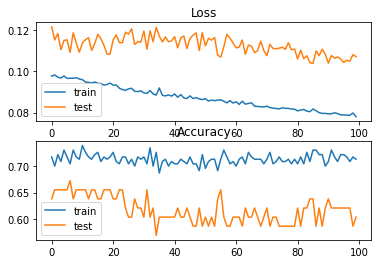

In [74]:
history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=100, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [49]:
model.save('models/Duel1.2')

INFO:tensorflow:Assets written to: models/Duel1.2\assets
